# EDA Section

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Parquet files in correct logical order
metadata_df = pd.read_parquet("speech_metadata.parquet")
transcriptions_df = pd.read_parquet("speech_transcriptions.parquet")
combined_df = pd.read_parquet("speech_combined.parquet")

# Display the shapes of the dataframes and preview the first few rows
print("Metadata DF shape:", metadata_df.shape)
display(metadata_df.head())
print("Transcriptions DF shape:", transcriptions_df.shape)
display(transcriptions_df.head())
print("Combined DF shape:", combined_df.shape)
display(combined_df.head())


Metadata DF shape: (2703, 6)


,id,user_id,chapter_id,recording_id,recording_length,recording_file
0,1,84,121123,1,2.09,84-121123-0000.flac
1,2,84,121123,2,3.99,84-121123-0001.flac
2,3,84,121123,3,13.69,84-121123-0002.flac
3,4,84,121123,4,6.80,84-121123-0003.flac
4,5,84,121123,5,4.40,84-121123-0004.flac


Transcriptions DF shape: (2703, 2)


,id,recording_transcriptions
0,1,Go! Do you hear?
1,2,But in less than five minutes the staircase gr...
2,3,at this moment the whole soul of the old man s...
3,4,"And the cry issued from his pores, if we may t..."
4,5,Davernier rushed towards the old man and made ...


Combined DF shape: (97, 4)


,user_id,chapter_id,recording_transcriptions,recording_length
0,84,121123,Go! Do you hear? But in less than five minutes...,166.785062
1,84,121550,but with full ravishment the hours of prime si...,314.464875
2,174,50561,"Forgotten, too, the name of Jillian, the lovel...",145.885000
3,174,84280,how we must simplify it seems to me more and m...,149.640062
4,174,168635,"He had never been father, lover, husband, frie...",187.030062


## Basic Info and Null Check

In [32]:
# Check for missing values
print("Missing values in Metadata DF:")
print(metadata_df.isnull().sum())

print("\nMissing values in Transcriptions DF:")
print(transcriptions_df.isnull().sum())

print("\nMissing values in Combined DF:")
print(combined_df.isnull().sum())


Missing values in Metadata DF:
id                  0
user_id             0
chapter_id          0
recording_id        0
recording_length    0
recording_file      0
dtype: int64

Missing values in Transcriptions DF:
id                          0
recording_transcriptions    0
dtype: int64

Missing values in Combined DF:
user_id                     0
chapter_id                  0
recording_transcriptions    0
recording_length            0
dtype: int64


There are no missing values in all df.

## Metadata df

### Recording Length

Recording Length (sec) Statistics:
count    2703.000000
mean        7.175775
std         4.695612
min         1.445000
25%         3.760000
50%         5.920000
75%         9.267500
max        32.645000
Name: recording_length, dtype: float64


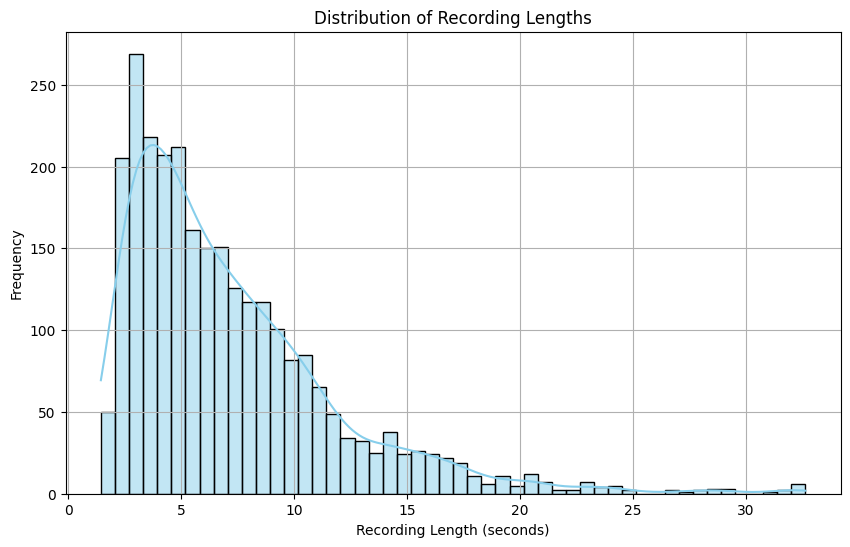

In [33]:
# 1. Summary statistics for recording length
print("Recording Length (sec) Statistics:")
print(metadata_df['recording_length'].describe())

# 2. Histogram of recording length
plt.figure(figsize=(10, 6))
sns.histplot(metadata_df['recording_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Recording Lengths")
plt.xlabel("Recording Length (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram shows the distribution of recording lengths in seconds. Most recordings are relatively short, with the highest frequency clustered between 2 to 6 seconds. The distribution is right-skewed, indicating a long tail of fewer but longer recordings extending up to around 30 seconds. This suggests that the dataset is dominated by short speech segments, which may reflect a design choice to keep recordings concise for easier processing or labeling.


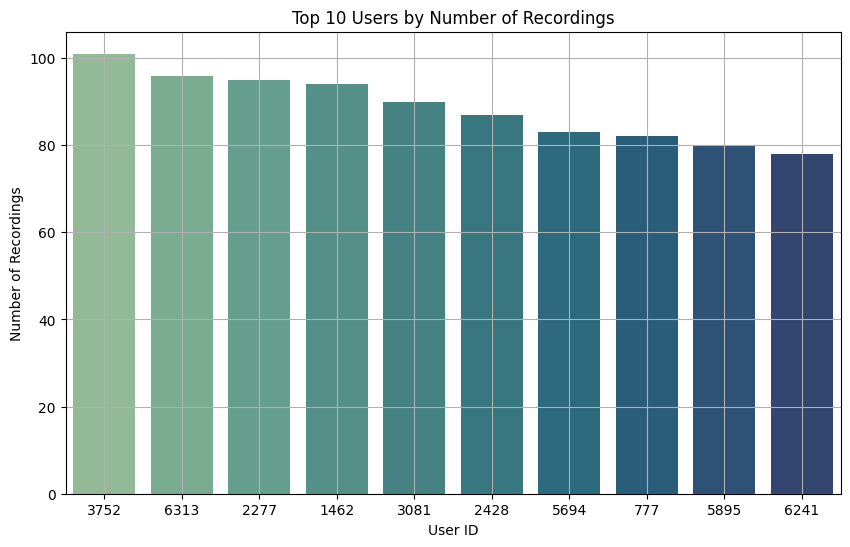

In [34]:
# Count number of recordings per user
user_counts = (
    metadata_df.groupby('user_id')
    .size()
    .reset_index(name='recording_count')
    .sort_values(by='recording_count', ascending=False)
)

# Convert user_id to string and set as ordered category
top_users = user_counts.head(10).copy()
top_users['user_id'] = top_users['user_id'].astype(str)
top_users['user_id'] = pd.Categorical(
    top_users['user_id'], 
    categories=top_users['user_id'], 
    ordered=True
)

# Plot without palette warning
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_users,
    x='user_id',
    y='recording_count',
    hue='user_id',
    dodge=False,
    palette='crest',
    legend=False
)
plt.title("Top 10 Users by Number of Recordings")
plt.xlabel("User ID")
plt.ylabel("Number of Recordings")
plt.grid(True)
plt.show()


The bar chart displays the top 10 most active users by number of recordings. User 3752 contributed the most with just over 100 recordings, while the others each contributed between roughly 78 and 100. The recording counts among these top users are fairly close, indicating a relatively balanced distribution of work. This suggests that recording assignments may have been evenly allocated or capped per user.


Total unique users: 40


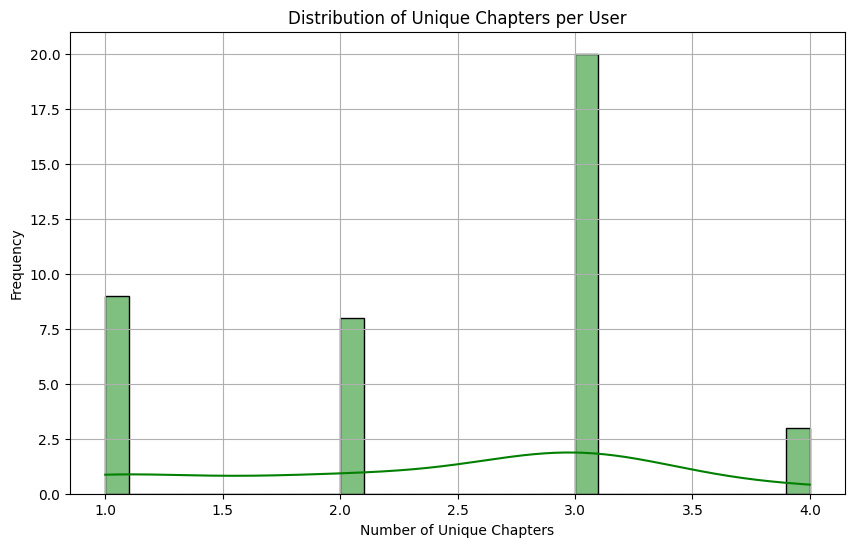

In [35]:
# Check how many unique users
num_users = metadata_df['user_id'].nunique()
print(f"Total unique users: {num_users}")

# Unique chapters per user
chapters_per_user = metadata_df.groupby('user_id')['chapter_id'].nunique().reset_index()
chapters_per_user.columns = ['user_id', 'unique_chapters']

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(chapters_per_user['unique_chapters'], bins=30, color='green', kde=True)
plt.title("Distribution of Unique Chapters per User")
plt.xlabel("Number of Unique Chapters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows the distribution of how many unique chapters each user contributed to. Most users worked on exactly 3 unique chapters, with smaller groups contributing to only 1 or 2. Very few users recorded for 4 chapters. This suggests that the work was fairly evenly distributed, with a majority of users taking on a moderate workload across multiple chapters.


## Transcriptions df

### Distribution of Transcription Lengths

Word Count Statistics:
count    2703.000000
mean       19.993711
std        13.436597
min         1.000000
25%        10.000000
50%        17.000000
75%        26.000000
max        89.000000
Name: word_count, dtype: float64


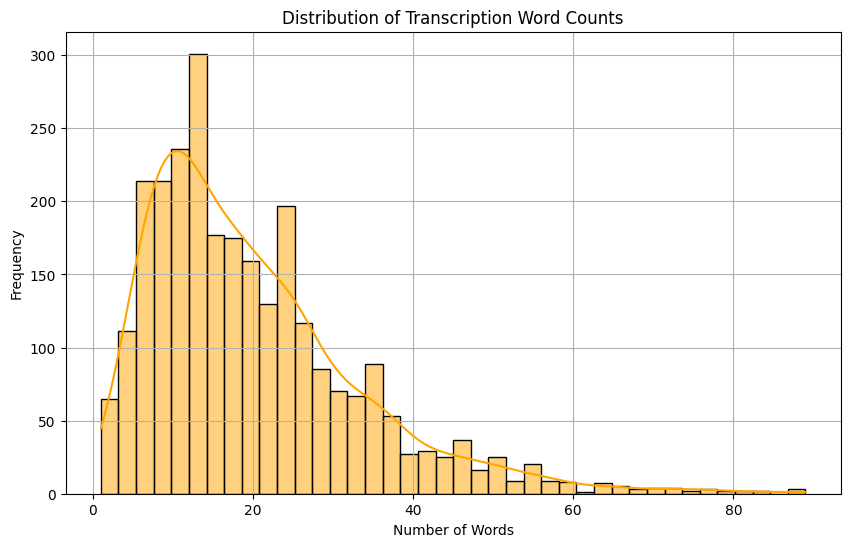

In [36]:
# Add a column that counts the number of words in each transcription
transcriptions_df['word_count'] = transcriptions_df['recording_transcriptions'].str.split().apply(len)

# Display basic statistics for word counts
print("Word Count Statistics:")
print(transcriptions_df['word_count'].describe())

# Plot the distribution of transcription word counts
plt.figure(figsize=(10, 6))
sns.histplot(transcriptions_df['word_count'], bins=40, kde=True, color='orange')
plt.title("Distribution of Transcription Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows the distribution of word counts in each transcription. Most transcriptions contain between 5 and 25 words, with a peak around 15. The distribution is right-skewed, indicating that while the majority of transcriptions are relatively short, a smaller number contain up to 80 or more words. This suggests a focus on concise spoken segments, with a few longer, possibly more complex sentences present in the dataset.


## Combined df

In [37]:
# Summary of recording lengths
print("Combined DF - Recording Length Statistics:")
print(combined_df['recording_length'].describe())


Combined DF - Recording Length Statistics:
count     97.000000
mean     199.960008
std      109.874046
min       41.980000
25%      141.580000
50%      171.115000
75%      203.815000
max      503.020000
Name: recording_length, dtype: float64


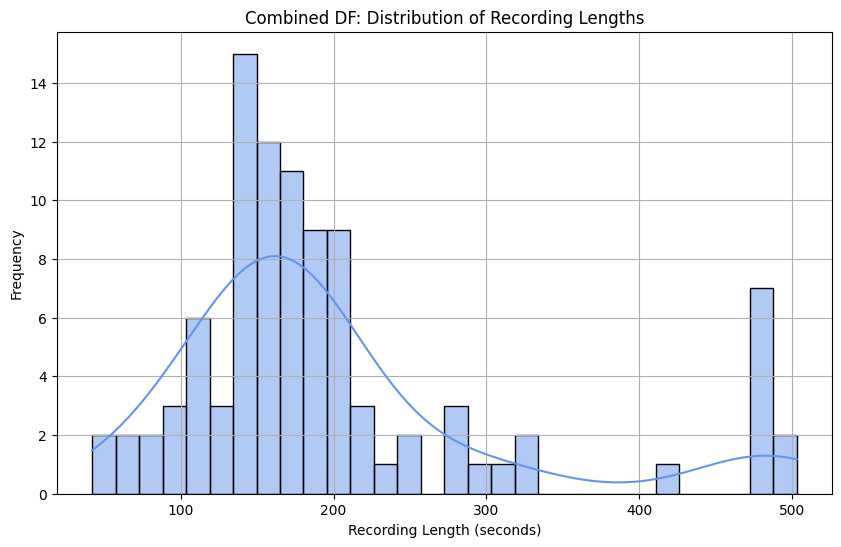

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['recording_length'], bins=30, color='cornflowerblue', kde=True)
plt.title("Combined DF: Distribution of Recording Lengths")
plt.xlabel("Recording Length (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


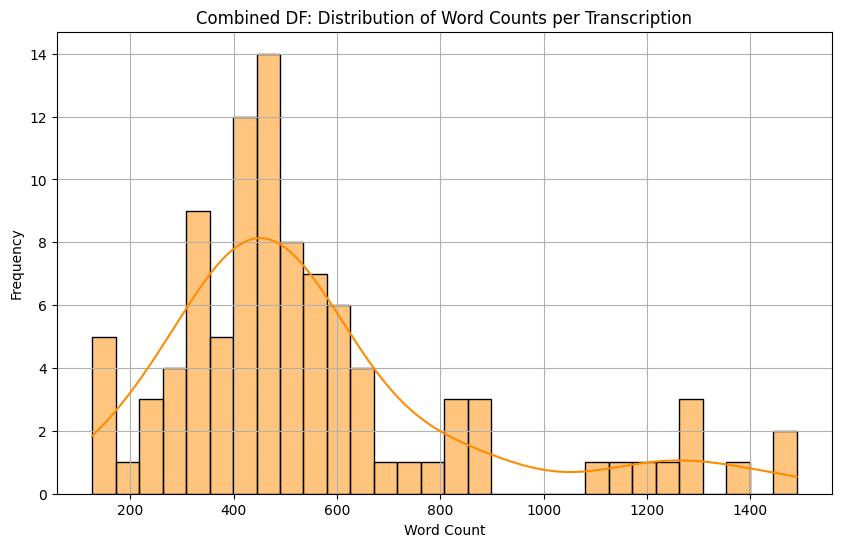

In [39]:
# Add word count column
combined_df['word_count'] = combined_df['recording_transcriptions'].str.split().apply(len)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['word_count'], bins=30, color='darkorange', kde=True)
plt.title("Combined DF: Distribution of Word Counts per Transcription")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Correlation Between Word Count and Duration

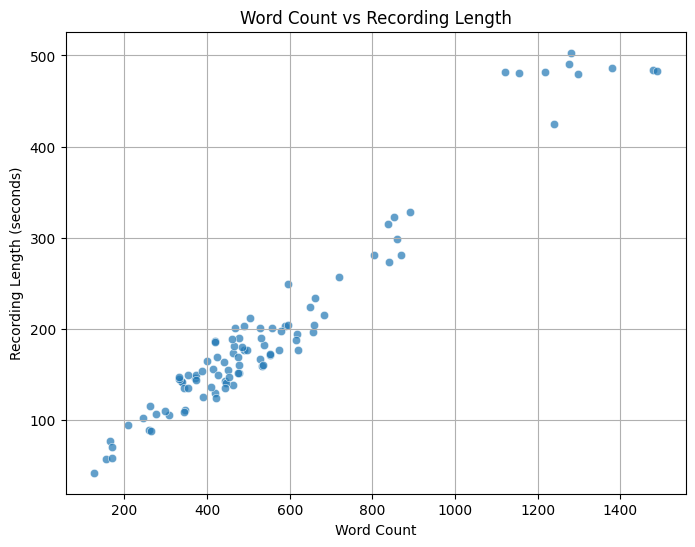

Pearson correlation between word count and recording length: 0.98


In [40]:
# Correlation Between Word Count and Duration
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x='word_count', y='recording_length', alpha=0.7)
plt.title("Word Count vs Recording Length")
plt.xlabel("Word Count")
plt.ylabel("Recording Length (seconds)")
plt.grid(True)
plt.show()

correlation = combined_df[['word_count', 'recording_length']].corr().iloc[0, 1]
print(f"Pearson correlation between word count and recording length: {correlation:.2f}")


The scatter plot shows a clear positive relationship between transcription word count and recording length. In general, recordings with higher word counts tend to have longer durations, forming an upward trend that suggests a roughly linear association. Most points are clustered in the 100–600 word and 100–250 second range, with a group of outliers beyond 1,000 words and 450 seconds. This indicates that longer transcriptions often correspond to significantly longer recordings, likely representing complete chapters or extended passages.

With a Pearson correlation coefficient of 0.98, the relationship between word count and recording length is extremely strong and positive. This near-perfect linear correlation confirms that longer transcriptions almost always correspond to longer recordings. The scatter plot visually supports this, showing a clear upward trend with minimal deviation. This suggests that in this dataset, word count can serve as a highly reliable indicator of recording duration, making it useful for quality control, segmentation, or estimating missing values.

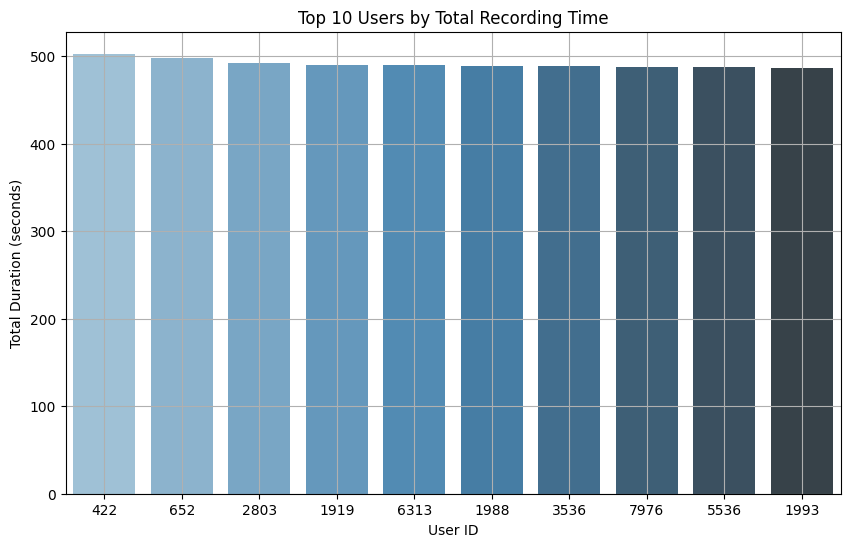

In [41]:
# Step 1: Aggregate total recording time per user
user_recording_time = (
    combined_df.groupby('user_id')['recording_length']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Step 2: Extract top 10 users
top_users = user_recording_time.head(10).copy()

# Step 3: Ensure user_id is treated as a properly ordered categorical variable
top_users['user_id'] = top_users['user_id'].astype(str)
top_users['user_id'] = pd.Categorical(
    top_users['user_id'],
    categories=top_users['user_id'],
    ordered=True
)

# Step 4: Plot without warning
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_users,
    x='user_id',
    y='recording_length',
    hue='user_id',
    dodge=False,
    palette='Blues_d',
    legend=False
)
plt.title("Top 10 Users by Total Recording Time")
plt.xlabel("User ID")
plt.ylabel("Total Duration (seconds)")
plt.grid(True)
plt.show()


The bar chart displays the top 10 users with the highest total recording time. Each user contributed between roughly 495 to 510 seconds, indicating a highly uniform distribution of total speech workload among these top contributors. This suggests the project may have had target time quotas or careful task balancing to ensure equitable contribution. While the IDs differ from those who had the highest number of recordings, it's possible that these users recorded fewer but longer segments.